In [1]:
import rebound 
print(rebound.__build__)
import numpy as np
import ctypes
from ctypes import POINTER, c_double, c_int,byref
%matplotlib inline
import matplotlib.pyplot as plt

Oct 17 2018 11:34:12


In [2]:
def move_to_hel(self):
    """
    Move to the heliocentric frame.
    """
    r = self.particles[0].xyz
    v = self.particles[0].vxyz
    for p in self.particles:
        p.x -= r[0]
        p.y -= r[1]
        p.z -= r[2]
        p.vx -= v[0]
        p.vy -= v[1]
        p.vz -= v[2]        
rebound.Simulation.move_to_hel = move_to_hel

In [16]:
def diffsim(sim1,sim2):
    """
    Returns a meassure for the difference between two simulations.
    """
    m = 0.
    for i in range(sim1.N):
        m = max(m,abs(sim1.particles[i].x-sim2.particles[i].x))
        m = max(m,abs(sim1.particles[i].y-sim2.particles[i].y))
        m = max(m,abs(sim1.particles[i].z-sim2.particles[i].z))
        m = max(m,abs(sim1.particles[i].vx-sim2.particles[i].vx))
        m = max(m,abs(sim1.particles[i].vy-sim2.particles[i].vy))
        m = max(m,abs(sim1.particles[i].vz-sim2.particles[i].vz))
    return m

In [54]:
mercury = ctypes.cdll.LoadLibrary("../mercury/mercury.so")
def mercury_step(self,rcrit=None,algor=1):
    """
    Monkey patch, allowing a REBOUND simulation to call a Mercury integrator
    """
    if self.G!=1.:
        raise ValueError("G must be set to 1.")
    if self.N<2:
        raise ValueError("Number of particles must be > 1.")
    if self.particles[0].m!=1.:
        raise ValueError("Mass of central object must be equal to 1.")
        
    nbod = c_int(self.N)
    nbig = nbod
    NMESS = 1 # number of messages
    CMAX = 1 # number of close encounter minima monitored simultaneously 
    if algor==1:
        step = mercury.mdt_mvsp_

    elif algor==10:
        step = mercury.mdt_hyp_
        if rcrit is None:
            raise ValueError("rcrit must be set for hybrid integrator.")
    else:
        raise ValueError("Integrator not implemented")
              
    step.argtypes = [
        POINTER(c_double), # real*8              time 
        POINTER(c_double), # real*8              tstart
        POINTER(c_double), # real*8              h0
        POINTER(c_double), # real*8              tol
        POINTER(c_double), # real*8              rmax
        POINTER(c_double*3), # real*8(3)           en
        POINTER(c_double*3), # real*8(3)           am
        POINTER(c_double*3), # real*8(3)           jcen
        POINTER(c_double), # real*8              rcen
        POINTER(c_int), # integer             nbod
        POINTER(c_int), # integer             nbig
        POINTER(c_double*nbod.value), # real*8(nbod)        m
        POINTER((c_double*3)*nbod.value), # real*8(3,nbod)      x
        POINTER((c_double*3)*nbod.value), # real*8(3,nbod)      v
        POINTER((c_double*3)*nbod.value), # real*8(3,nbod)      s
        POINTER(c_double*nbod.value), # real*8(nbod)        rphys
        POINTER(c_double*nbod.value), # real*8(nbod)        rcrit
        POINTER(c_double*nbod.value), # real*8(nbod)        rce
        POINTER(c_int), # integer(nbod)       stat
        POINTER((c_double*4)*nbod.value), # real*8(4,nbod)      ngf
        POINTER(c_int), # integer             algor
        POINTER(c_int*8),# integer(8)          opt
        POINTER(c_int), # integer             dtflag
        POINTER(c_int), # integer             ngflag
        POINTER(c_int), # integer             opflag
        POINTER(c_int), # integer             colflag
        POINTER(c_int), # integer             nclo
        POINTER(c_int*CMAX), # integer(CMAX)       iclo
        POINTER(c_int*CMAX), # integer(CMAX)       jclo
        POINTER(c_double*CMAX), # real*8(CMAX)        dclo
        POINTER(c_double*CMAX), # real*8(CMAX)        tclo
        POINTER(c_double*CMAX), # real*8(CMAX)        ixvclo
        POINTER(c_double*CMAX), # real*8(CMAX)        jxvclo
        POINTER(c_int*NMESS),# integer(NMESS)     lmem
        ]

    time = c_double(0.)
    tstart = c_double(0.)
    h0 = c_double(self.dt)
    tol = c_double(1e-16)
    rmax = c_double(100.)
    DoubleArray3 = c_double * 3
    en = DoubleArray3(0.,0.,0.)
    am = DoubleArray3(0.,0.,0.)
    jcen = DoubleArray3(0.,0.,0.)
    rcen = c_double(0.)
    DoubleArrayNBOD = c_double * nbod.value
    DoubleArray3NBOD = (c_double * 3)* nbod.value
    _m = []
    _x = []
    _v = []
    _s = []
    for p in self.particles:
        _m.append(p.m)
        _x.append(DoubleArray3(p.x,p.y,p.z))
        _v.append(DoubleArray3(p.vx,p.vy,p.vz))
        _s.append(DoubleArray3(0.,0.,0.))
    m = DoubleArrayNBOD(*_m)
    x = DoubleArray3NBOD(*_x)
    v = DoubleArray3NBOD(*_v)
    s = DoubleArray3NBOD(*_s)
    rphys = DoubleArrayNBOD(*[0. for i in range(nbod.value)])
    if rcrit is None:
        rcrit = DoubleArrayNBOD(*[0. for i in range(nbod.value)])
    else:
        rcrit = DoubleArrayNBOD(*rcrit) 
    rce = DoubleArrayNBOD(*[0. for i in range(nbod.value)])
    stat = c_int(0)
    DoubleArray4 = (c_double * 4)
    DoubleArray4NBOD = (c_double * 4) * nbod.value
    ngf = DoubleArray4NBOD(*[DoubleArray4(0,0,0,0) for i in range(nbod.value)])
    algor = c_int(algor)
    IntArray8 = c_int*8
    opt = IntArray8(0,1,1,2,0,1,0,0)
    dtflag = c_int(0)
    ngflag = c_int(0)
    opflag = c_int(0)
    colflag = c_int(0)
    nclo = c_int(1)
    iclo = (c_int*1)(0)
    jclo = (c_int*1)(0)
    dclo = (c_double*1)(0.)
    tclo = (c_double*1)(0.)
    ixvclo = (c_double*1)(0.)
    jxvclo = (c_double*1)(0.)
    lmem = (c_int*1)(0)

    step(byref(time), byref(tstart), byref(h0), byref(tol), byref(rmax), byref(en), byref(am), byref(jcen), byref(rcen),
         byref(nbod), byref(nbig), byref(m), byref(x), byref(v), byref(s), byref(rphys), byref(rcrit), byref(rce), byref(stat),
         byref(ngf), byref(algor), byref(opt), byref(dtflag), byref(ngflag), byref(opflag), byref(colflag), byref(nclo),
         byref(iclo), byref(jclo), byref(dclo), byref(tclo), byref(ixvclo), byref(jxvclo), byref(lmem))
    for i,p in enumerate(self.particles):
        self.particles[i].x = x[i][0]
        self.particles[i].y = x[i][1]
        self.particles[i].z = x[i][2]
        self.particles[i].vx = v[i][0]
        self.particles[i].vy = v[i][1]
        self.particles[i].vz = v[i][2]
    self.t += self.dt
rebound.Simulation.mercury_step = mercury_step

In [55]:
def setup_sim():
    sim = rebound.Simulation()
    sim.add(m=1)
    sim.add(a=1,e=0.1,f=0.9,omega=4.9,m=0.001)
    sim.add(a=1.1,omega=0.3,f=0.5,e=0.2,m=0.001)
    sim.dt = 0.05
    return sim

In [56]:
def step_manual(self,algo):
    if algo == "mercuryhybrid":
        rcrit = [0.0, 0.2, 0.4]
        self.mercury_step(rcrit=rcrit, algor=10)
    elif algo == "mercurymvs":
        self.mercury_step(algor=1)        
    elif algo == "mercurius":
        self.integrator = "mercurius"
        self.ri_whfast.coordinates = "democraticheliocentric"
        self.step()
    elif algo == "whfast":
        self.integrator = "whfast"
        self.ri_whfast.coordinates = "jacobi"
        self.step()
    elif algo == "whfastcor":
        self.integrator = "whfast"
        self.ri_whfast.coordinates = "jacobi"
        self.ri_whfast.corrector = 11
        self.step()
    elif algo == "whfastdh":
        self.integrator = "whfast"
        self.ri_whfast.coordinates = "democraticheliocentric"
        self.step()    
    elif algo == "ias15":
        self.integrator = "ias15"
        self.integrate(self.t+self.dt,exact_finish_time=1)            
    else:
        raise ValueError("Not defined")
rebound.Simulation.step_manual = step_manual

In [57]:
algos = ["mercurius","mercuryhybrid","mercurymvs","whfast","whfastcor","whfastdh","ias15"]
steps = 200
energy = np.zeros([len(algos),steps])
times = np.zeros(steps)
simdiff = np.zeros([len(algos)-1,steps])
sims = []
for i,algo in enumerate(algos):
    sims.append(setup_sim())
sims[0].move_to_com()
e0 = sims[0].calculate_energy()
for i,algo in enumerate(algos):
    sims[i].move_to_hel()
for k in range(steps):
    for i,algo in enumerate(algos):
        sims[i].move_to_hel() # Do all integrations in the heliocentric frame   
        sims[i].step_manual(algo)
        sims[i].move_to_com() # move back to the COM frame to compare results
        energy[i,k] = np.abs((e0-sims[i].calculate_energy())/e0)
        times[k] = sims[i].t
        if i>0:
            simdiff[i-1,k] = diffsim(sims[0],sims[i])     

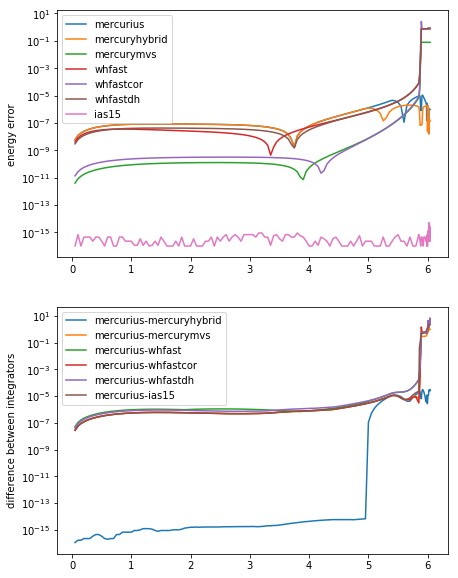

In [58]:
fig, ax = plt.subplots(2,1,figsize=(7,10))
ax[0].set_yscale("log")
for i,algo in enumerate(algos):
    ax[0].plot(times,np.maximum(energy[i,:],1e-16),label=algo)
ax[0].legend();
ax[0].set_ylabel("energy error");
ax[1].set_yscale("log")
for i,algo in enumerate(algos):
    if i>0:
        ax[1].plot(times,simdiff[i-1],label=algos[0]+"-"+algo)
ax[1].legend();
ax[1].set_ylabel("difference between integrators");